# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [101]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, min as Fmin, max as Fmax, sum as Fsum, desc, avg
from pyspark.sql.types import IntegerType, DateType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, MinMaxScaler 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import pandas as pd
import datetime

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Features") \
    .getOrCreate()

# Read data
df = spark.read.json('mini_sparkify_event_data.json')

# Print the schema information
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Get the size of the dataset
print(df.count())

286500


In [4]:
# Get an overview about null and empty fields
for struct in df.schema:
    name = struct.name
    countNull = df.where(col(name).isNull()).count()
    countEmpty  = df.where(col(name) == "").count()
    print("Name: {0}, Count Null: {1}, Count Empty: {2}".format(name, countNull, countEmpty))

Name: artist, Count Null: 58392, Count Empty: 0
Name: auth, Count Null: 0, Count Empty: 0
Name: firstName, Count Null: 8346, Count Empty: 0
Name: gender, Count Null: 8346, Count Empty: 0
Name: itemInSession, Count Null: 0, Count Empty: 0
Name: lastName, Count Null: 8346, Count Empty: 0
Name: length, Count Null: 58392, Count Empty: 0
Name: level, Count Null: 0, Count Empty: 0
Name: location, Count Null: 8346, Count Empty: 0
Name: method, Count Null: 0, Count Empty: 0
Name: page, Count Null: 0, Count Empty: 0
Name: registration, Count Null: 8346, Count Empty: 0
Name: sessionId, Count Null: 0, Count Empty: 0
Name: song, Count Null: 58392, Count Empty: 0
Name: status, Count Null: 0, Count Empty: 0
Name: ts, Count Null: 0, Count Empty: 0
Name: userAgent, Count Null: 8346, Count Empty: 0
Name: userId, Count Null: 0, Count Empty: 8346


There are 8346 rows where the userId is empty. Since there are also 8346 rows where first name and last name is missing (probably the same rows) there exists no substitute for user id. Therefore these rows will be removed.

In [5]:
# Remove rows without userId
df = df.filter(df.userId != "")

# Check, that filter works
print("User ID NULL count: {0}".format(df.filter(df.userId == '').count()))

User ID NULL count: 0


In [6]:
# Check for null and empty rows after cleaning

for struct in df.schema:
    name = struct.name
    countNull = df.where(col(name).isNull()).count()
    countEmpty  = df.where(col(name) == "").count()
    print("Name: {0}, Count Null: {1}, Count Empty: {2}".format(name, countNull, countEmpty))

Name: artist, Count Null: 50046, Count Empty: 0
Name: auth, Count Null: 0, Count Empty: 0
Name: firstName, Count Null: 0, Count Empty: 0
Name: gender, Count Null: 0, Count Empty: 0
Name: itemInSession, Count Null: 0, Count Empty: 0
Name: lastName, Count Null: 0, Count Empty: 0
Name: length, Count Null: 50046, Count Empty: 0
Name: level, Count Null: 0, Count Empty: 0
Name: location, Count Null: 0, Count Empty: 0
Name: method, Count Null: 0, Count Empty: 0
Name: page, Count Null: 0, Count Empty: 0
Name: registration, Count Null: 0, Count Empty: 0
Name: sessionId, Count Null: 0, Count Empty: 0
Name: song, Count Null: 50046, Count Empty: 0
Name: status, Count Null: 0, Count Empty: 0
Name: ts, Count Null: 0, Count Empty: 0
Name: userAgent, Count Null: 0, Count Empty: 0
Name: userId, Count Null: 0, Count Empty: 0


In [7]:
# Get a sample of rows where artist is missing
df.filter(df.artist.isNull()).head(3)

[Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=84, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='GET', page='Roll Advert', registration=1538331630000, sessionId=8, song=None, status=200, ts=1538353150000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=86, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='T

There are still 50046 (17 %) rows, where essential information like artist or song is missing. Probably these are page hits that don't involve a song like landing page hits.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Definition of Churn

Within this project churn is defined as a cancellation of service. In case a "Cancellation Confirmation" event for a user is detected, this user is considered to have churned. There might 
be multiple cancellation confirmations, due to the fact, that a user reregistered after cancellations but cancelled again.

Downgrades of service from paid to free tier are not considered as churn.

In [8]:
churn = udf(lambda x: int(x == 'Cancellation Confirmation'), IntegerType())
downgrade_churn = udf(lambda x: int(x == 'Submit Downgrade'), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

### Exploration of Data

In [9]:
# Now we compute the number of users that downgraded or cancelled. 
# There might be multiple downgrade events, hence the signum function is used. 

signum = udf(lambda x: int(x>0), IntegerType())

# The status of each user
user_status = df.select(["userId", "downgraded", "cancelled"]) \
    .groupby("userId").sum() 

user_status = user_status \
    .withColumn('downgraded', signum(col("sum(downgraded)"))) \
    .withColumn('cancelled', signum(col("sum(cancelled)")))

In [10]:
# A quick check, that the previous functions work
user_status.show(5)

+------+---------------+--------------+----------+---------+
|userId|sum(downgraded)|sum(cancelled)|downgraded|cancelled|
+------+---------------+--------------+----------+---------+
|100010|              0|             0|         0|        0|
|200002|              0|             0|         0|        0|
|   125|              0|             1|         0|        1|
|    51|              0|             1|         0|        1|
|   124|              0|             0|         0|        0|
+------+---------------+--------------+----------+---------+
only showing top 5 rows



In [11]:
# Get the time intervall of the data
# Used some stuff from the following website: https://databricks.com/blog/2015/09/16/apache-spark-1-5-dataframe-api-highlights.html

print( 'Min timestamp = ' + str( datetime.datetime.utcfromtimestamp( df.agg(Fmin(col("ts"))).collect()[0][0]/1000  ).strftime('%c') ) )
print( 'Max timestamp = ' + str( datetime.datetime.utcfromtimestamp( df.agg(Fmax(col("ts"))).collect()[0][0]/1000  ).strftime('%c') ) )

Min timestamp = Mon Oct  1 00:01:57 2018
Max timestamp = Mon Dec  3 01:11:16 2018


The data set contains data for 63 days, around 2 months.

In [13]:
# Create a more human friendly time column

get_date_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("date_time", get_date_time(df.ts))

In [14]:
# Get the number of users
df.select("userId").dropDuplicates().count()

225

In [15]:
# Get the number of sessions

df.select("sessionId").dropDuplicates().count()

2312

In [16]:
# Get the amount of events for the different levels
df.groupby('level').count().sort('count', ascending = False).show()

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



There around 4 times more events for paid users than for free users. Paid users are much more active.

In [17]:
# Get the gender distribution
df.groupby('gender').count().sort('count', ascending = False).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



We have more or less the same amount of events for male and female users.

In [18]:
# Get the page distribution
df.groupby('page').count().sort('count', ascending = False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



The number of cancelations is quite low, only 52. 

In [19]:
user_status.agg({ 'downgraded' : 'sum', 'cancelled': 'sum'}).show()

+---------------+--------------+
|sum(downgraded)|sum(cancelled)|
+---------------+--------------+
|             49|            52|
+---------------+--------------+



Aggregating rows does not change the number of cancellations. The number of downgrades is 49.

The total number of unique users is 225. Therefore 21.7% of users downgraded and 23% cancelled.

In [20]:
# Number of songs and artists

print( 'Number of songs: ' + str(df.select("song").drop_duplicates().count()))
print( 'Number of artists: ' + str(df.select("artist").drop_duplicates().count()))

Number of songs: 58481
Number of artists: 17656


In [21]:
# Use the spark windowing functions for data analysis.
window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [22]:
# Using the window function defined above, we can estimate the churn phase

df = df.withColumn("churn_phase", Fsum("cancelled").over(window))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(window))

In [24]:
# A quick check, that the function worked.

df.head(3)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgraded=0, cancelled=0, date_time='2018-11-21 18:12:32', churn_phase=0, downgrade_phase=0),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D2

In [25]:
# Define an udf, that counts songs 

song = udf(lambda x : int(x=='NextSong'), IntegerType())

In [26]:
# Can we detect any difference with respect to the number of songs played between the 2 groups.

df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [27]:
# Is there any difference on the number of songs played per day ? An additional udf is defined.

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [28]:
# Use the get_day udf to get the number of songs per day

df.filter((df.page=='NextSong')&(col('churn_phase')==1)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

df.filter((df.page=='NextSong')&(col('churn_phase')==0)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037885|71.24764235703725|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493976|74.02407951472078|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



There seems to be a difference between the number of songs per day, this is a candidate for a feature.

In [29]:
# Is the listening length a useful feature ?

df.filter(col('cancelled')==1).agg({'length':'mean'}).show()
df.filter(col('cancelled')==0).agg({'length':'mean'}).show()

+-----------+
|avg(length)|
+-----------+
|       null|
+-----------+

+-----------------+
|      avg(length)|
+-----------------+
|249.1171819778458|
+-----------------+



In [46]:
# Get the number of users who downgraded or cancelled

print(df.filter(col('downgraded')==1).select('userId').dropDuplicates().count(), 
      df.filter(col('cancelled')==1).select('userId').dropDuplicates().count())

49 52


49 users downgraded and 52 users cancelled.

In [47]:
# Get the number of users who downgraded and cancelled

df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==1)&(col("cancelled")==1))\
    .count()

9

In [30]:
# Do users typically downgrade before cancelling ? Is downgrading a predictor of cancelling ?

user_status.where(col("cancelled") == 1).groupby("downgraded").count().show()

+----------+-----+
|downgraded|count|
+----------+-----+
|         1|    9|
|         0|   43|
+----------+-----+



In [50]:
# The number of paid users that cancelled

print(df.filter((col('cancelled')==1) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [51]:
# The number of free users that cancelled

print(df.filter((col('cancelled')==1) & (col('level')=='free'))\
      .select('userId').dropDuplicates().count())

21


In [48]:
# The number of users that cancelled without a downgrade

df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

Summary of downgrading and cancelling:

49 users downgraded and 52 users cancelled.

In case of the 52 users who cancelled, 9 downgraded before cancelling, 43 cancelled without a downgrade.
In case of the 52 users who cancelled, 31 are paid users, 21 are free users.

In [31]:
# Look at the session data of some random user

df.select(["userId", "page", "date_time", "level", "song", "sessionId"]).where(df.userId == "30").sort("date_time").show(25)

+------+---------------+-------------------+-----+--------------------+---------+
|userId|           page|          date_time|level|                song|sessionId|
+------+---------------+-------------------+-----+--------------------+---------+
|    30|       NextSong|2018-10-01 00:01:57| paid|           Rockpools|       29|
|    30|       NextSong|2018-10-01 00:06:34| paid|   Time For Miracles|       29|
|    30|       NextSong|2018-10-01 00:11:16| paid|Harder Better Fas...|       29|
|    30|       NextSong|2018-10-01 00:14:59| paid|Passengers (Old A...|       29|
|    30|Add to Playlist|2018-10-01 00:15:05| paid|                null|       29|
|    30|       NextSong|2018-10-01 00:18:04| paid|          Fuck Kitty|       29|
|    30|       NextSong|2018-10-01 00:20:18| paid|                Jade|       29|
|    30|       NextSong|2018-10-01 00:24:01| paid|   So-Called Friends|       29|
|    30|       NextSong|2018-10-01 00:28:07| paid|           Represent|       29|
|    30|       N

In [32]:
# Addtional columns dealing with date and time, for consistency redefinition of get_day udf

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn("day", get_day(df.ts))

In [34]:
# Look again at the same user data

df.select(["userId", "page", "weekday", "day", "hour", "level", "song", "sessionId"]).where(df.userId == "30").sort("date_time").show(25)

+------+---------------+-------+---+----+-----+--------------------+---------+
|userId|           page|weekday|day|hour|level|                song|sessionId|
+------+---------------+-------+---+----+-----+--------------------+---------+
|    30|       NextSong|      1|  1|   0| paid|           Rockpools|       29|
|    30|       NextSong|      1|  1|   0| paid|   Time For Miracles|       29|
|    30|       NextSong|      1|  1|   0| paid|Harder Better Fas...|       29|
|    30|       NextSong|      1|  1|   0| paid|Passengers (Old A...|       29|
|    30|Add to Playlist|      1|  1|   0| paid|                null|       29|
|    30|       NextSong|      1|  1|   0| paid|          Fuck Kitty|       29|
|    30|       NextSong|      1|  1|   0| paid|                Jade|       29|
|    30|       NextSong|      1|  1|   0| paid|   So-Called Friends|       29|
|    30|       NextSong|      1|  1|   0| paid|           Represent|       29|
|    30|       NextSong|      1|  1|   0| paid|     

In [35]:
# Exporting data to a csv file.

df.select(["userId", "page", "weekday", "day", "hour", "level", "song", "sessionId"]).where(df.userId == "30").sort("date_time").toPandas().to_csv("user.csv")


In [37]:
def plot_usage_rate_versus_time(time): 
    """
    Plot usage of service against different time units.
    """
    df_pd = df.filter(df.page == "NextSong").groupby("churn_phase", time).count().orderBy(df[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn_phase==0].plot.bar(x=time, y='count', color='Green', label='No churn')
    df_pd[df_pd.churn_phase==1].plot.bar(x=time, y='count', color='Red', label='Churn')

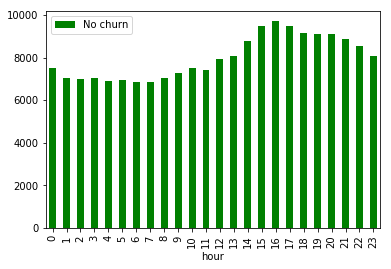

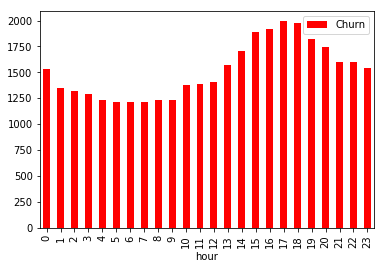

In [39]:
# Is there any difference accross hours ?

plot_usage_rate_versus_time("hour")

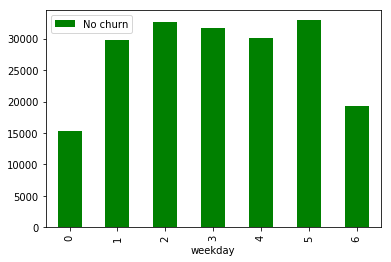

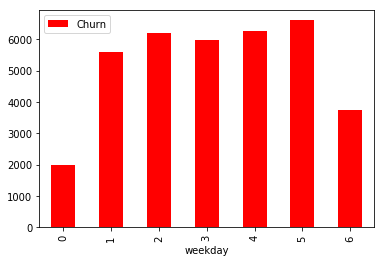

In [40]:
# Is there any difference accross days of the week ?

plot_usage_rate_versus_time("weekday")

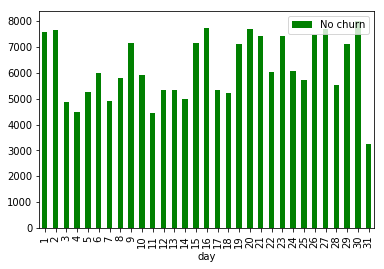

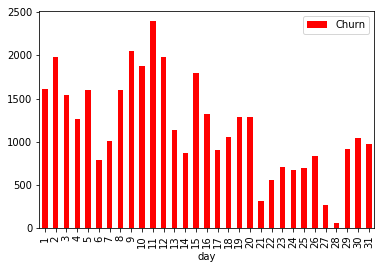

In [41]:
# Is there any difference accross the month ?

plot_usage_rate_versus_time("day")

There is a significant difference between the 2 data sets plotted againt the day of the month.

In [42]:
# Thumbs up and thumbs down per user and day

thumbs_up_perday_avg = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_up_perday_avg')
    
thumbs_down_perday_avg = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_down_perday_avg')

In [44]:
# Get the first few rows of the result

thumbs_up_perday_avg.head(5)

[Row(userId='100010', thumbs_up_perday_avg=2.8333333333333335),
 Row(userId='200002', thumbs_up_perday_avg=3.0),
 Row(userId='124', thumbs_up_perday_avg=7.125),
 Row(userId='51', thumbs_up_perday_avg=8.333333333333334),
 Row(userId='7', thumbs_up_perday_avg=1.75)]

In [45]:
# Get the first few rows of the result

thumbs_down_perday_avg.head(5)

[Row(userId='100010', thumbs_down_perday_avg=1.25),
 Row(userId='200002', thumbs_down_perday_avg=3.0),
 Row(userId='124', thumbs_down_perday_avg=2.1578947368421053),
 Row(userId='51', thumbs_down_perday_avg=2.1),
 Row(userId='7', thumbs_down_perday_avg=1.0)]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Feature 1: Session Count

In [52]:
# Feature 1: Session Count
    
session_count = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
session_count = session_count.withColumnRenamed("count", "session_count")    

In [53]:
session_count.show(10)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            7|
|200002|            6|
|   125|            1|
|    51|           10|
|   124|           29|
|     7|            7|
|    54|           37|
|    15|           15|
|   155|            6|
|100014|            6|
+------+-------------+
only showing top 10 rows



### Feature 2: Songs per Session

In [54]:
session_songs = df.filter(df.page=="NextSong").groupby("userId", "sessionId").count()
session_songs_avg = session_songs.groupby("userId").agg(avg(session_songs["count"]).alias("session_songs_avg")).sort("userId")

In [55]:
session_songs_avg.show(5)

+------+------------------+
|userId| session_songs_avg|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



### Feature 3: Count of different artists

In [56]:
artist_count = df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
artist_count = artist_count.withColumnRenamed("count", "artist_count")

In [57]:
artist_count.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



### Feature 4: Days since registration

In [58]:
max_ts = df.groupby("userId").max("ts").sort("userId")
reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")
# Joint both datasets on user id
days_since_registration = reg_ts.join(max_ts, reg_ts.userId == max_ts.userId) \
.select(reg_ts["userId"], ((max_ts["max(ts)"]-reg_ts["registration"])/(1000*60*60*24)).alias("days_since_registration"))

In [59]:
days_since_registration.show(5)

+------+-----------------------+
|userId|days_since_registration|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



### Feature 5: Average time per session

In [60]:
session_time = df.groupby("userId", "sessionId")\
.agg(((Fmax(df.ts)-Fmin(df.ts))/(1000*60)).alias("sessionTime"))
session_time_avg = session_time.groupby("userId")\
.agg(avg(session_time.sessionTime).alias("session_time_avg")).sort("userId")

In [61]:
session_time_avg.show(5)

+------+------------------+
|userId|  session_time_avg|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
|100001|148.15833333333333|
|100002|201.18333333333334|
|100003| 99.11666666666667|
+------+------------------+
only showing top 5 rows



### Feature 6: Average songs per day

In [62]:
songs_perday_avg = df.where(df.page == "NextSong") \
    .select(["userId", "day"]) \
    .groupby( [ "userId", "day" ] ).count() \
    .withColumnRenamed("count", "songs_perday") \
    .groupby( [ "userId" ] ).agg( { "songs_perday" : "avg"}) \
    .withColumnRenamed("avg(songs_perday)", "songs_perday_avg")


In [63]:
songs_perday_avg.show(5)

+------+------------------+
|userId|  songs_perday_avg|
+------+------------------+
|100010|39.285714285714285|
|200002|55.285714285714285|
|   125|               8.0|
|   124|            163.16|
|    51| 162.3846153846154|
+------+------------------+
only showing top 5 rows



### Feature 7: Level (free or paid)

In [64]:
# One hot encoding of subscription level

free = udf(lambda x: int(x=='free'), IntegerType())
paid = udf(lambda x: int(x=='paid'), IntegerType())

level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

level.show(5)

+------+----+----+
|userId|free|paid|
+------+----+----+
|100021|   1|   0|
|200021|   1|   0|
|200001|   1|   0|
|     6|   1|   0|
|300022|   0|   1|
+------+----+----+
only showing top 5 rows



### Feature 8: Average Thumbs up per day

In [65]:
thumbs_up_perday_avg = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_up_perday_avg')

In [66]:
thumbs_up_perday_avg.show(5)

+------+--------------------+
|userId|thumbs_up_perday_avg|
+------+--------------------+
|100010|  2.8333333333333335|
|200002|                 3.0|
|   124|               7.125|
|    51|   8.333333333333334|
|     7|                1.75|
+------+--------------------+
only showing top 5 rows



### Feature 9: Average Thumbs down

In [67]:
thumbs_down_perday_avg = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_down_perday_avg')

In [68]:
thumbs_down_perday_avg.show(5)

+------+----------------------+
|userId|thumbs_down_perday_avg|
+------+----------------------+
|100010|                  1.25|
|200002|                   3.0|
|   124|    2.1578947368421053|
|    51|                   2.1|
|     7|                   1.0|
+------+----------------------+
only showing top 5 rows



### Feature 10: Daily errors

In [69]:
daily_errors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'daily_errors')

In [70]:
daily_errors.show(5)

+------+------------+
|userId|daily_errors|
+------+------------+
|   124|         1.2|
|    51|         1.0|
|     7|         1.0|
|    15|         1.0|
|    54|         1.0|
+------+------------+
only showing top 5 rows



Collect the computation of the different features and the churn phase in a single method.

In [71]:
def create_feature_df(filepath='mini_sparkify_event_data.json'):
    
    """
    This method creates a result with following structure:
    
    root
     |-- userId: string
     |-- churn_phase: bigint
     |-- downgrade_phase: bigint
     |-- session_count: bigint
     |-- session_songs_avg: bigint
     |-- artist_count: bigint
     |-- days_since_registration: double
     |-- session_time_avg: double
     |-- songs_perday_avg: double
     |-- free: int 
     |-- paid: int 
     |-- thumbs_up_perday_avg: double 
     |-- thumbs_down_perday_avg: double 
     |-- daily_errors: double 
    
    """
    # Get the data from the json file
    df = spark.read.json(filepath)
    
    # Remove rows without userId
    df = df.filter(df.userId != "")

    # Define udf's for churn and downgrade columns
    churn = udf(lambda x: int(x == 'Cancellation Confirmation'), IntegerType())
    downgrade_churn = udf(lambda x: int(x == 'Submit Downgrade'), IntegerType())

    df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))
    
    # Use a window function to get the churn phase of the user
    window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn("churn_phase", Fsum("cancelled").over(window))\
           .withColumn("downgrade_phase", Fsum("downgraded").over(window))
    
    
    # We will merge all the feature dataframes with the user dataframe.
    users = df.where((df.userId != "") | (df.sessionId != "")) \
    .select('userId', 'churn_phase', 'downgrade_phase').dropDuplicates()       
    
    # Add helper features
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    df = df.withColumn("day", get_day(df.ts))

    # Feature 1, Session Count
    session_count = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
    session_count = session_count.withColumnRenamed("count", "session_count")  
    
    # Feature 2, Songs per Session
    session_songs = df.filter(df.page=="NextSong").groupby("userId", "sessionId").count()
    session_songs_avg = session_songs.groupby("userId").agg(avg(session_songs["count"])\
                                                            .alias("session_songs_avg")).sort("userId")
    # Feature 3, Artist count
    artist_count = df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
    artist_count = artist_count.withColumnRenamed("count", "artist_count")
    
    # Feature 4,  Days since registration
    max_ts = df.groupby("userId").max("ts").sort("userId")
    reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")
    # Joint both datasets on user id
    days_since_registration = reg_ts.join(max_ts, reg_ts.userId == max_ts.userId) \
    .select(reg_ts["userId"], ((max_ts["max(ts)"]-reg_ts["registration"])/(1000*60*60*24)).alias("days_since_registration"))

    # Feature 5, Average time per session
    session_time = df.groupby("userId", "sessionId")\
    .agg(((Fmax(df.ts)-Fmin(df.ts))/(1000*60)).alias("sessionTime"))
    session_time_avg = session_time.groupby("userId")\
    .agg(avg(session_time.sessionTime).alias("session_time_avg")).sort("userId")

    # Feature 6, songs per day (average)   
    songs_perday_avg = df.where(df.page == "NextSong") \
    .select(["userId", "day"]) \
    .groupby( [ "userId", "day" ] ).count() \
    .withColumnRenamed("count", "songs_perday") \
    .groupby( [ "userId" ] ).agg( { "songs_perday" : "avg"}) \
    .withColumnRenamed("avg(songs_perday)", "songs_perday_avg")

    # Feature 7, Subscription level, One-Hot encoded 
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())

    level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')
    
    # Feature 8, Average Thumbs up per day
    thumbs_up_perday_avg = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_up_perday_avg')
    
    # Feature 9, Average Thumbs down per day
    thumbs_down_perday_avg = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean() \
        .withColumnRenamed('avg(count(page))', 'thumbs_down_perday_avg')
   
    # Feature 10, daily errors (average)
    daily_errors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'daily_errors')
    
    # Join all the features to a result dataframe
    df = users.join(session_count, on='userId') \
        .join(session_songs_avg, on='userId') \
        .join(artist_count, on='userId') \
        .join(days_since_registration, on='userId') \
        .join(session_time_avg, on='userId') \
        .join(songs_perday_avg, on='userId') \
        .join(level, on='userId') \
        .join(thumbs_up_perday_avg, on='userId') \
        .join(thumbs_down_perday_avg, on='userId') \
        .join(daily_errors, on='userId')
    
    
    return df


In [72]:
new_df = create_feature_df()
new_df.show(5)

+------+-----------+---------------+-------------+------------------+------------+-----------------------+------------------+------------------+----+----+--------------------+----------------------+------------+
|userId|churn_phase|downgrade_phase|session_count| session_songs_avg|artist_count|days_since_registration|  session_time_avg|  songs_perday_avg|free|paid|thumbs_up_perday_avg|thumbs_down_perday_avg|daily_errors|
+------+-----------+---------------+-------------+------------------+------------+-----------------------+------------------+------------------+----+----+--------------------+----------------------+------------+
|   124|          0|              0|           29|145.67857142857142|        2232|     131.55591435185184| 578.9942528735633|            163.16|   0|   1|               7.125|    2.1578947368421053|         1.2|
|    51|          1|              0|           10|             211.1|        1385|     19.455844907407407| 872.3566666666666| 162.3846153846154|   0|   

In [107]:
out_path = "features.csv"
new_df.write.save(out_path, format="csv", header=True)

In [73]:
new_df.persist()

DataFrame[userId: string, churn_phase: bigint, downgrade_phase: bigint, session_count: bigint, session_songs_avg: double, artist_count: bigint, days_since_registration: double, session_time_avg: double, songs_perday_avg: double, free: int, paid: int, thumbs_up_perday_avg: double, thumbs_down_perday_avg: double, daily_errors: double]

In [74]:
# Use pandas to get a nice overview of the columns

pd = new_df.toPandas()
pd.head(5)

,userId,churn_phase,downgrade_phase,session_count,session_songs_avg,artist_count,days_since_registration,session_time_avg,songs_perday_avg,free,paid,thumbs_up_perday_avg,thumbs_down_perday_avg,daily_errors
0,124,0,0,29,145.678571,2232,131.555914,578.994253,163.160000,0,1,7.125000,2.157895,1.2
1,51,1,0,10,211.100000,1385,19.455845,872.356667,162.384615,0,1,8.333333,2.100000,1.0
2,7,0,0,7,21.428571,142,72.778183,87.640476,18.750000,1,0,1.750000,1.000000,1.0
3,15,0,0,15,136.714286,1302,56.513576,528.283333,112.588235,0,1,5.785714,1.555556,1.0
4,54,1,0,37,81.171429,1744,110.751690,322.289640,118.375000,1,0,7.761905,1.705882,1.0


In [75]:
# Convert all features to numeric features and scale features

def scale_features(df):
    """
    This method converts all features to numeric features and scales them.
    In additon a feature_vector column and a label columns are created.
    """
    numeric_cols = df.drop('userId', 'churn_phase').columns
    
    df = df.withColumn("label", df["churn_phase"].cast(DoubleType()))
    
    vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol='feature_vector') 
    min_max_scaler = MinMaxScaler(inputCol="feature_vector", outputCol="features")
    
    df = vector_assembler.transform(df)
    min_max_scaler_model = min_max_scaler.fit(df)
    result_df = min_max_scaler_model.transform(df)
    
    return result_df[['label', 'features']]

In [77]:
# Create a new dataframe, suitable for Spark Machine Learning

scaled_df = scale_features(new_df)

In [78]:
# Convert to a Pandas dataframe and get a look at the first few rows.

scaled_df.toPandas().head()

,label,features
0,0.0,"[0.0, 0.264150943396, 0.471789839882, 0.621028..."
1,1.0,"[0.0, 0.0849056603774, 0.716890415236, 0.37637..."
2,0.0,"[0.0, 0.0566037735849, 0.00628874715668, 0.017..."
3,0.0,"[0.0, 0.132075471698, 0.438205254003, 0.352397..."
4,1.0,"[0.0, 0.339622641509, 0.230114624682, 0.480069..."


In [79]:
# Save the pandas data frame

scaled_df.toPandas().to_csv("scaled_df.csv")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [108]:
# Split the  data into training and validation data sets.
# Due to the small number of users, that churn we will use 40 % of the data for validation and testing

train, validation = scaled_df.randomSplit([0.6, 0.4], seed=42)

In [82]:
# Create a helper function used to report classification results

def get_metrics(model, train, test, fields = ['label', 'probability', 'prediction']):
    """
    This is a helper function used to collect several classifier results.
    """
    model_preds_train = model.transform(train)
    model_preds_test = model.transform(test)
    
    evaluator_roc = BinaryClassificationEvaluator(metricName = 'areaUnderROC')
    auc_train = evaluator_roc.evaluate(model_preds_train)
    auc_test = evaluator_roc.evaluate(model_preds_test)
    
    # Computer classification results for training data
    preds_train_df = model_preds_train.select(fields).toPandas()
    train_f1_score = f1_score(preds_train_df.label, preds_train_df.prediction)
    train_precision = precision_score(preds_train_df.label, preds_train_df.prediction)
    train_recall = recall_score(preds_train_df.label, preds_train_df.prediction)
    train_accuracy = accuracy_score(preds_train_df.label, preds_train_df.prediction)
    
    # Now the same stuff for test data
    preds_test_df = model_preds_test.select(fields).toPandas()  
    
    test_f1_score = f1_score(preds_test_df.label, preds_test_df.prediction)
    test_precision = precision_score(preds_test_df.label, preds_test_df.prediction)
    test_recall = recall_score(preds_test_df.label, preds_test_df.prediction)
    test_accuracy = accuracy_score(preds_test_df.label, preds_test_df.prediction)  
    
    print("Area Under ROC (training): {0}\n" \
          "Area Under ROC (test): {1}\n" \
          "F1 Score (training): {2}\n" \
          "F1 Score (test): {3}\n" \
          "Precision (training): {4}\n" \
          "Precision (test): {5}\n" \
          "Recall (training): {6}\n" \
          "Recall (test): {7}\n" \
          "Accuracy (training): {8}\n" \
          "Accuracy (test): {9}\n" \
          .format(\
            auc_train, \
            auc_test, 
            train_f1_score, \
            test_f1_score, \
            train_precision, \
            test_precision, \
            train_recall, \
            test_recall, \
            train_accuracy, \
            test_accuracy
            ))
                                            
    return \
        auc_train, \
        auc_test, \
        train_f1_score, \
        test_f1_score, \
        train_precision, \
        test_precision, \
        train_recall, \
        test_recall, \
        train_accuracy, \
        test_accuracy
        

Use several classification algorithms with 3-fold crossvalidation and grid search for optimal parameters.

### Decision Tree classifier

In [109]:
# Use a decision tree classifier 

dtc = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.impurity,['entropy']) \
    .addGrid(dtc.maxDepth,[2, 5]) \
    .build()

dtc_crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

dtc_model = dtc_crossval.fit(train)

In [105]:
# Get the key metrics

dtc_model.avgMetrics

[0.7873582959940908, 0.8324015032213643]

In [106]:
# Save the model

dtc_model.save('dtc.model')

In [116]:
# Report Results
get_metrics(dtc_model, train, validation)

Area Under ROC (training): 0.9904524699045247
Area Under ROC (test): 0.9348684210526316
F1 Score (training): 0.9393939393939394
F1 Score (test): 0.823529411764706
Precision (training): 0.9393939393939394
Precision (test): 0.7777777777777778
Recall (training): 0.9393939393939394
Recall (test): 0.875
Accuracy (training): 0.9776536312849162
Accuracy (test): 0.9459459459459459



(0.9904524699045247,
 0.9348684210526316,
 0.93939393939393945,
 0.82352941176470595,
 0.93939393939393945,
 0.77777777777777779,
 0.93939393939393945,
 0.875,
 0.97765363128491622,
 0.94594594594594594)

### Logistic Regression

In [111]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
lr_model = lr_crossval.fit(train)

In [113]:
# Get the key metrics
lr_model.avgMetrics

[0.8073334000784982,
 0.7511156590890047,
 0.8073334000784982,
 0.7318535593608317,
 0.8073334000784982,
 0.7318535593608317]

In [114]:
# Save the model

lr_model.save('lr.model')

In [115]:
# Report results
get_metrics(lr_model, train, validation)

Area Under ROC (training): 0.8111249481112497
Area Under ROC (test): 0.7875000000000003
F1 Score (training): 0.391304347826087
F1 Score (test): 0.3
Precision (training): 0.6923076923076923
Precision (test): 0.75
Recall (training): 0.2727272727272727
Recall (test): 0.1875
Accuracy (training): 0.8435754189944135
Accuracy (test): 0.8738738738738738



(0.8111249481112497,
 0.7875000000000003,
 0.39130434782608697,
 0.29999999999999999,
 0.69230769230769229,
 0.75,
 0.27272727272727271,
 0.1875,
 0.84357541899441346,
 0.87387387387387383)

### Support Vector Maschine

In [129]:
svm =  LinearSVC()
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter,[10]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

svm_crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
svm_model = svm_crossval.fit(train)

In [130]:
# Get the key metrics
svm_model.avgMetrics

[0.7423440725231008, 0.7423440725231008]

In [132]:
# Save the model
svm_model.write().overwrite().save('svm.model')

In [134]:
# Report results
get_metrics(svm_model, train, validation, fields=['label', 'features', 'rawPrediction', 'prediction'])

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Area Under ROC (training): 0.7588210875882114
Area Under ROC (test): 0.7756578947368423
F1 Score (training): 0.0
F1 Score (test): 0.0
Precision (training): 0.0
Precision (test): 0.0
Recall (training): 0.0
Recall (test): 0.0
Accuracy (training): 0.8156424581005587
Accuracy (test): 0.8558558558558559



(0.7588210875882114,
 0.7756578947368423,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.81564245810055869,
 0.85585585585585588)

### GBT Classifier (Gradient Boosted Trees)

In [124]:
gbt =  GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10]) \
    .addGrid(gbt.maxDepth,[2, 5, 10]) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
gbt_model = gbt_crossval.fit(train)

In [125]:
# Get the key metrics
gbt_model.avgMetrics

[0.7874424925090457,
 0.8684023968498964,
 0.8907479357938564,
 0.8394952649526444,
 0.8868338214224705,
 0.8907479357938564]

In [127]:
# Save the model
gbt_model.save('gbt.model')

In [128]:
# Report results
get_metrics(gbt_model, train, validation)

Area Under ROC (training): 1.0
Area Under ROC (test): 0.9476973684210526
F1 Score (training): 1.0
F1 Score (test): 0.8571428571428572
Precision (training): 1.0
Precision (test): 0.7894736842105263
Recall (training): 1.0
Recall (test): 0.9375
Accuracy (training): 1.0
Accuracy (test): 0.954954954954955



(1.0,
 0.9476973684210526,
 1.0,
 0.85714285714285721,
 1.0,
 0.78947368421052633,
 1.0,
 0.9375,
 1.0,
 0.95495495495495497)

## Conclusion

The GBT classifier produced the best results. An F1 score of 85.7 % was reached.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.